<a href="https://colab.research.google.com/github/hyunjune123/Q-trader/blob/master/lstm_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Library

In [1]:
pip install alpha_vantage

     |████████████████████████████████| 1.3MB 6.9MB/s 
     |████████████████████████████████| 296kB 25.9MB/s 
     |████████████████████████████████| 143kB 34.9MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=151a03d895fcaabdfd42c0111d51022eb196d1132b7a5891f4cdec2389aaf076
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [2]:
# Libraries used
import random
from datetime import datetime
import time
import pickle as pk
import os
import pdb

import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.initializers import glorot_uniform, Constant
from keras.regularizers import l2
import keras.backend as K
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import tensorflow as tf

import numpy as np
import pandas as pd
import math


from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import Image

import alpha_vantage
from alpha_vantage.timeseries import TimeSeries

# Functions

In [156]:
def get_daily(symb):
    ts = TimeSeries(key=api_key, output_format='pandas')
    msft_df_full, meta_data = ts.get_daily_adjusted(symbol=symb, outputsize='full')
    msft_df_full = msft_df_full.drop(['4. close', '7. dividend amount', '8. split coefficient'], axis=1)

    msft_df_full.columns = ["Open", "High", "Low", "Close", "Volume"]
    msft_df_full = msft_df_full.iloc[::-1]
    return msft_df_full

def get_intraday(symb, inter):
    ts = TimeSeries(key=api_key, output_format='pandas')
    msft_df_full, meta_data = ts.get_intraday(symbol=symb, outputsize='full', interval = inter)
    #msft_df_full = msft_df_full.drop(['4. close', '7. dividend amount', '8. split coefficient'], axis=1)

    msft_df_full.columns = ["Open", "High", "Low", "Close", "Volume"]
    msft_df_full = msft_df_full.iloc[::-1]
    return msft_df_full

def ewm_display(msft_df, window):
    fig, (ax1, ax2) = plt.subplots(2)
    close = (msft_df['Close'])[0:1000]
    x = list(range(0, len(close)))
    y = close
    ax1.plot(x,y)
    ax1.set_title = "Simple harmonic motion stock price"
    ax1.set_xlabel = "Timestep"
    ax1.set_ylabel = 'Price'
    y = (y.ewm(com = window)).mean()
    ax2.plot(x,y)
    ax2.set_title = "Simple harmonic motion stock price"
    ax2.set_xlabel = "Timestep"
    ax2.set_ylabel = 'Price'
    plt.show()

def state_rp(msft_df, window):
    train_len = int(len(msft_df)*0.9) 
    ex_prices = msft_df['Close_ex'].values
    prices = msft_df['Close'].values
    X_train = []
    y_train = []
    prices = []
    for i in range(window, len(msft_df)):
        prices += [prices[i]]
        x = ex_prices[i-window:i]
        x = (x-np.mean(x))/np.std(x)
        X_train.append(x)
        y_train.append(trai[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y= np.reshape(y_train, (X_train.shape[0],2))

    return (X[0:train_len], y[0:train_len], X[train_len:], y[train_len:],
            prices[0:train_len], prices[train_len:])

from scipy.stats import linregress

def bin_state_rp (df, window):
    train_len = int(len(df)*0.9) 
    ex_prices = df['Close_ex'].values
    real_prices = df['Close'].values
    volumes = df['Volume_ex'].values
    X_train = []
    y_train = []
    prices = []
    for i in range(window, len(df)):
        prices += [real_prices[i-1]]
        px = real_prices[i-window:i]
        x = ex_prices[i-window:i]
        v = volumes[i-window:i]
        px = (px-np.mean(px))/np.std(px)
        x = (x-np.mean(x))/np.std(x)
        v = (x-np.mean(v))/np.std(v)
        xv = [[px[j], x[j], v[j]] for j in range(0, len(x))]
        X_train.append(xv)
        
        ys = []
        slope, intercept, r_value, p_value, std_err = linregress([range(0, window)], real_prices[i+1-window:i+1])
        #for yi in range(i, i+1):
        if ex_prices[i] - ex_prices[i-1] < 0:
        #if slope < 0:
            y = [1,0]
        else:
            y = [0,1]
        y_train.append(y)

    X_train, y_train = np.array(X_train), np.array(y_train)
    X = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))
    y= np.reshape(y_train, (X_train.shape[0],2))

    return (X_train, y_train, prices)

tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

def lstm(X_train, y_train, nest_step, epoch, v):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta = 0.0001,
                                              patience=5)
    split = len(X_train)-nest_step
    (X, X_val, y, y_val) = (X_train[0:split], X_train[split:], y_train[0:split], y_train[split:])


    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = False, input_shape = (X.shape[1], X.shape[2])))
    #model.add(LSTM(units = 32, return_sequences = False, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dense(2, activation = 'softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    history3 = model.fit(X, y, epochs = epoch, batch_size = 8,
                         validation_data=(X_val, y_val), callbacks = [callback],
                         verbose = v)
    if v:
        # print model acc
        fig, loss_ax = plt.subplots()
        acc_ax = loss_ax.twinx()

        loss_ax.plot(history3.history['loss'], 'y', label='train loss')
        loss_ax.plot(history3.history['val_loss'], 'r', label='val loss')
        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        loss_ax.legend(loc='upper right')
        acc_ax.plot(history3.history['accuracy'], 'b', label='train acc')
        acc_ax.plot(history3.history['val_accuracy'], 'g', label='val acc')
        acc_ax.set_ylabel('accuracy')
        acc_ax.legend(loc='upper left')

        plt.show()
    model.save("lstm_model")
    return (model, history3)

def plot_test(model_name, name, margin, X_test, P_test, t_i):
    model = load_model(model_name)
    low = 0.5 - margin
    hi = 0.5 + margin
    mypredict = model.predict(X_test)
    my_result = []
    my_trend = []
    for i in range(len(mypredict)):
        pred = (mypredict[i])[1]
        my_result.append(pred)
        if pred < low:
            my_trend += ["down"]
        elif pred > hi:
            my_trend += ["up"]
        else:
            my_trend += ["hold"]
    
    colors = {'down' : 'red', 'hold' : 'black', 'up' : 'blue'}
    legends = ['red', 'black', 'blue']

    fig, (ax1, ax2) = plt.subplots(2)
    ax1.scatter(list(range(0,len(P_test))), P_test,
                c = [colors[x] for x in my_trend],
                s=3)
    for xc in ([i for i in range(len(my_trend)) if my_trend[i] == "hold"]):
        ax1.axvline(x = xc, linestyle = '--', color = 'gainsboro')    
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in legends]
    labels = ['down', 'hold', 'up']
    ax1.legend(lines, labels,loc="lower right")
    ax1.set_title('LSTM model MSFT Backtest')
    ax1.set_ylabel("Price")

    ax2.plot(list(range(0,len(my_result))), my_result, linewidth=1)
    ax2.set_ylabel("Model Output")

    my_file = str(name)+"_lstm_backtest_"+str(t_i)+".png"
    fig.savefig(my_file)
    plt.close()

def plot_output(model, name, margin, X_test, P_test):
    if len(X_test) > 1000:
        X_tests = np.array_split(X_test, 5)
        P_tests = np.array_split(P_test, 5)
        for i in range(0, len(X_tests)):
            plot_test(model, name, margin, X_tests[i], P_tests[i], i)
    else:
        plot_test(model, name, margin, X_test, P_test, 0)

def index_strat(model_name, X_test, P_test, q):
    model = load_model(model_name)
    preds = [pred[1] for pred in model.predict(X_test)]
    inventory = 0
    b_inventory = inventory
    cash = P_test[0]*q 
    b_cash = P_test[0]*q
    principal = q * P_test[0]
    trends = []
    shift = 0
    buy = 0
    prof = 0
    profit = 0

    trade_hist = pd.DataFrame(columns=['Price', 'Action','Inventory', 'Profit'])
    for ti in range(0, len(preds)):
        pred = preds[ti]
        trends += [np.sign(pred-0.5)]
        if len(trends) > 20: trends = trends[1:]
        trend = sum(trends)
        p = P_test[ti]
        act = "None"
        if shift == 0 and trend < 0: # at down trend get rdy to buy
            shift = 1
        elif shift == 1: # enter when trend shifts back up
            if trend > 0:
                act = "Buy"
                buy = p
                shift = 2
                bi = ti
        elif shift == 2:  # time to sell when trend shifts back down
            prof = (p-buy)/buy
            if trend < 0 or ((pred < 0.5 and prof < 0) or (pred < 0.5 and prof > 0.2)):  # regular or quick sell
                act = "Sell"
                shift = 3
        if buy != 0: prof = (p-buy)/buy
        trade_hist.loc[ti] = [p, act, inventory, prof]
        if shift == 3:
            break
    trade_hist.to_csv("index_backtest.csv")
    return trade_hist


def plot_backtest(backtest, name):
    for index, row in backtest.iterrows():
        if row['Action'] == "Sell":
            plt.axvline(index, color = 'lightcoral', linewidth = 1)
        elif row['Action'] == "Buy":
            plt.axvline(index, color = 'lightskyblue', linewidth = 1)
    plt.plot([i for i in range(0, len(backtest))], backtest["Price"], color = 'k',
             alpha=0.9)
    c = {"Buy":"lightskyblue", "Sell":"lightcoral"}
    legends = ["Blue","Red"]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in legends]
    labels = ['Buy', 'Sell']
    plt.legend(lines, labels,loc="upper right")
    plt.savefig(name+'.png')
    plt.show()
    plt.close()

def nestedCv(stock, interval, quantity):
    cv = pd.DataFrame(columns=['stock',
                               'Accuracy', 
                                'Val_Accuracy', 
                                'Profit'])
                                #'Buy_hold_profit'])
    
    # df = get_intraday(stock, "15min")

    msft_df = get_daily(stock)
    spy_df = get_daily("SPY")
    window = 50
    spy_df['Close_ex'] = ((spy_df['Close']).ewm(com = window)).mean()
    spy_df['Volume_ex'] = ((spy_df['Volume'])) #.ewm(com = 10)).mean()
    spy_df = spy_df[["Close_ex", "Volume_ex"]]
    msft_df = msft_df[["Close"]]
    df=pd.merge(spy_df,msft_df, how='inner', left_index=True, right_index=True)
    df = df[0:(interval*(len(df)//interval))]

    (Xs, ys, prices) = bin_state_rp(df, 100)

    for i in range(1000, len(Xs), interval):
        print(i)
        X_train = Xs[0:i]
        y_train = ys[0:i]
        (model, hist) = lstm(X_train, y_train, interval, 1, False)
        backtest = index_strat("lstm_model", 
                                   Xs[i:len(Xs)], 
                                   prices[i:len(prices)],
                                   100)
        train_backtest = index_strat("lstm_model", Xs[i:len(Xs)], prices[i:len(prices)], 100)
        '''
        plot_backtest(train_backtest, "index_train")
        print(train_backtest.loc[train_backtest['Action'] != "None"])
        print(train_backtest.iloc[-1])
        '''
        cv.loc[i] = [stock,
                     hist.history['accuracy'][-1],
                     hist.history['val_accuracy'][-1],
                     list(backtest["Profit"])[-1]]
                     #list(backtest["Buyhold_Profit"])[-1]]
        print(list(backtest["Profit"])[-1])
        
    cv.loc['mean'] = cv.mean()
    cv.to_csv(stock+"_backtest.csv")




# Data collection

We collect data by using Alpha Vantage API. We can get free access by obtaining a key at https://www.alphavantage.co/support/#api-key. Put your obtained key in the first line in the code chunk below.

In [4]:
api_key = '8TMSJT1WD6USMGI1'

We can now fetch historical price data by using alpha vantage api. Documentation can be found in https://www.alphavantage.co/documentation/.
For this experiment we will use Microsoft's Daily Stock prices.

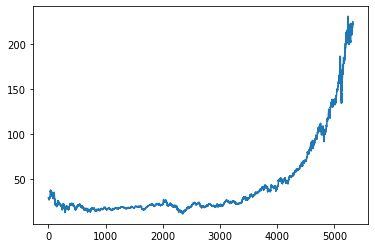

In [47]:
#msft_df = get_intraday("AAPL","15min")
msft_df = get_daily("MSFT")
spy_df = get_daily("SPY")
#msft_df
plt.plot([i for i in range(0, len(msft_df))],msft_df['Close'])
plt.show()


We apply exponential smoothing to price and volume columns to remove noises that deviate from general trend. Below is an example of exponential smoothing. This dramatically improves the model's prediction in general price trend.

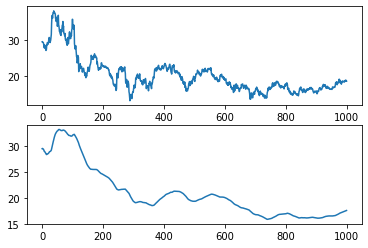

In [6]:
ewm_display(msft_df, 50)

In [48]:
window = 50
spy_df['Close_ex'] = ((spy_df['Close']).ewm(com = window)).mean()
spy_df['Volume_ex'] = ((spy_df['Volume'])) #.ewm(com = 10)).mean()
spy_df = spy_df[["Close_ex", "Volume_ex"]]
msft_df = msft_df[["Close"]]
msft_df=pd.merge(spy_df,msft_df, how='inner', left_index=True, right_index=True)


# Input Data Pre-processing

We plan to use LSTM model for trend prediction. We have 5224 samples with 50-day timestep 2 features, so the input dimension is (5224, 50, 2).

In [59]:
(Xs, ys, prices) = bin_state_rp(msft_df, 100)
print(len(Xs), len(ys), len(prices))

/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in sqrt
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


5224 5224 5224


# Training the LSTM model

For specific model architecture / parameters, refer to the structure of the LSTM model in the function lstm() above in the Functions section. Training process will take less than a minute. For this example, we train the model on the first 1,000 days.

The model estimates 0 if it determines that the price is at a down trend or 1 if is at an uptrend.

Training accuracy is about 80% and validation accuracy is about 90% after a single epoch. More training will result in overtraining. The model has successfully learned to predict the trend. 

113/113 [==============================] - 8s 40ms/step - loss: 0.5548 - accuracy: 0.7542 - precision_181: 0.7542 - recall_181: 0.7542 - val_loss: 0.2310 - val_accuracy: 0.9100 - val_precision_181: 0.9100 - val_recall_181: 0.9100


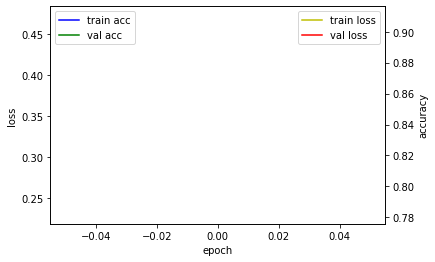

INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


--- 12.762805223464966 seconds ---


In [149]:
start_time = time.time()
lo = 1000
(inital_model, history) = lstm(Xs[0:lo], ys[0:lo], 100, 1, v = True)
print("--- %s seconds ---" % (time.time() - start_time))

# Backtest 

We can come up with a trade strategy based on the model's prediction. The LSTM model's output tells us how certain the price is at either an up or down trend.

The more the model output is closer to 1, we see that the price is in up-trend. When output is closer to 0, the price is in down-trend.

Below is the model prediction for the next 150 days (day 1,000 ~ 1,150). Observe that the model predicts an alternating pattern of down and up trends. We will use the model output to determine the time of entry and exit.

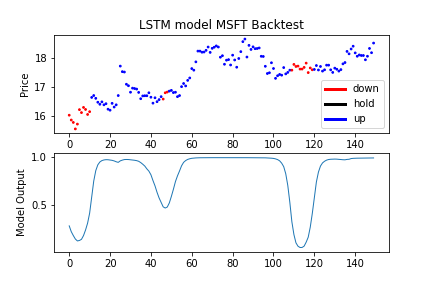

In [154]:
low = 1000
plot_output("lstm_model", "train", 0, Xs[low:low+150],prices[low:low+150])
Image('train_lstm_backtest_0.png')

One strategy could be to...
- Enter after the first down trend ends.
- Hold on to position during up trend.
- Exit when up trend ends and the next down trend starts.

We apply this strategy from day 1,000 then the model enters at day 1,021 and *exits* at day 1,120, yielding 7% profit.

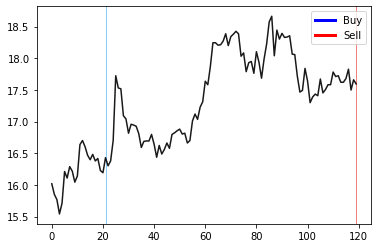

         Price Action Inventory     Profit
21   16.431106    Buy         0          0
119  17.596060   Sell         0  0.0708993
Price          17.5961
Action            Sell
Inventory            0
Profit       0.0708993
Name: 119, dtype: object


In [155]:
l = 1000
train_backtest = index_strat("lstm_model", Xs[l:len(Xs)], prices[l:len(prices)], 100)
plot_backtest(train_backtest, "index_train")
print(train_backtest.loc[train_backtest['Action'] != "None"])
print(train_backtest.iloc[-1])



## Backtesting on multiple time frames




We want to see if the model learns as well as the example trial above for different time periods and different stocks. We will try the backtesting the model on Microsoft, Apple and Amazon stock with 100 day time intervals. That is about 40 trades for each stocks.

All three boxplots are heavily right skewed with an average median around 13% and an average mean around 27%. While the 1st quantile for all three distribution is near -1.6 ~ -1.7%, the 3rd quantile is above 25%.

The model however does have some risk of negative outlier like minimum profit of -17.75% resulted from trading Amazon stock.

In [ ]:
nestedCv("MSFT", 100, 100)
nestedCv("AAPL", 100, 100)
nestedCv("AMZN", 100, 100)

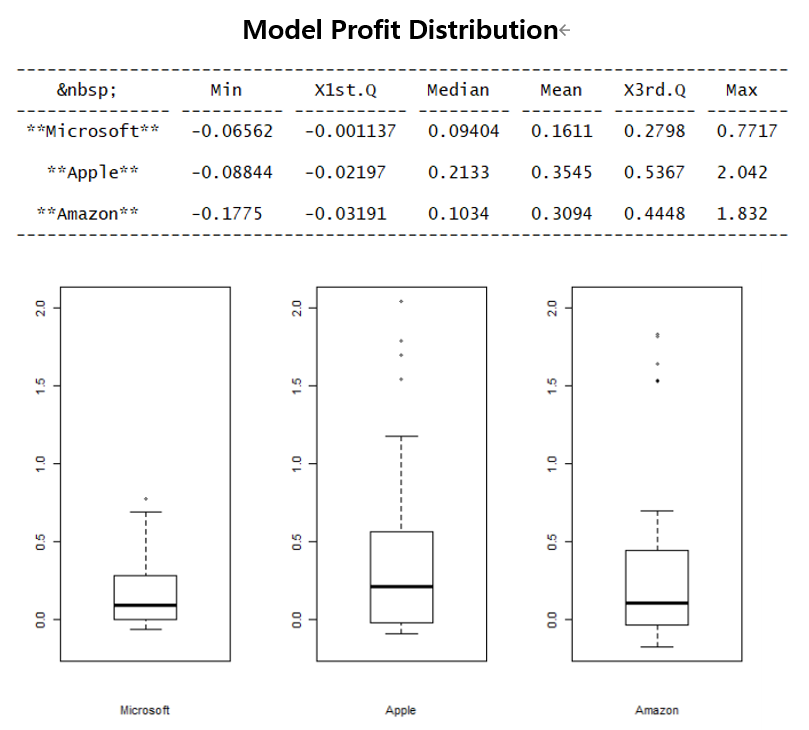

In [160]:
Image('distribution.PNG', width="400")